In [1]:
import os
import pickle
import matplotlib
import sklearn
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from feature_engine.selection import SelectBySingleFeaturePerformance
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler,
    PowerTransformer,
    FunctionTransformer
)
from feature_engine.encoding import (
	RareLabelEncoder,
    MeanEncoder,
    CountFrequencyEncoder
)
from feature_engine.datetime import DatetimeFeatures

In [2]:
warnings.filterwarnings('ignore')
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (11, 4)
matplotlib.rcParams['figure.facecolor'] = '#00000000'
sns.set_style('darkgrid')

In [3]:
PROJECT_DIR = 'R:\Jaydeep/Flight-Price-Prediction'
DATA_DIR = 'data'

TRAIN_DATASET_NAME = 'train'
VAL_DATASET_NAME = 'validation'
TEST_DATASET_NAME  = 'test'

TRAIN_PRE_DATASET_NAME = 'train_preprocessing'
VAL_PRE_DATASET_NAME = 'val_preprocessing'
TEST_PRE_DATASET_NAME = 'test_preprocessing'

def get_dataset(dataset_name):
    file_name = f'{dataset_name}.csv'
    file_path = os.path.join(PROJECT_DIR, DATA_DIR, file_name)
    return pd.read_csv(file_path)


X_train = get_dataset(TRAIN_PRE_DATASET_NAME)
X_val = get_dataset(VAL_PRE_DATASET_NAME)
X_test = get_dataset(TEST_PRE_DATASET_NAME)

y_train = get_dataset(TRAIN_DATASET_NAME)['price']
y_val = get_dataset(VAL_DATASET_NAME)['price']
y_test = get_dataset(TEST_DATASET_NAME)['price']

In [4]:
def get_metrics(model, X, y):
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    n = len(y)
    p = X.shape[1]
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    print(f'R^2: {r2:.4f}')
    print(f'Adjusted R^2: {adj_r2:.4f}')
    print(f'RMSE: {rmse:.4f}')

In [5]:
def get_dict_metrics(model, X, y):
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    n = len(y)
    p = X.shape[1]
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    return {
         'R^2' : r2,
         'Adjusted R^2' : adj_r2,
         'RMSE' : rmse
    }

## BASE

In [6]:
dummy_regressor = DummyRegressor(strategy="mean")
dummy_regressor.fit(X_train, y_train)
get_metrics(dummy_regressor, X_val, y_val)

R^2: -0.0000
Adjusted R^2: -0.0127
RMSE: 4657.5561


## Model Building

In [7]:
models = [LinearRegression(), SVR(),  KNeighborsRegressor(), DecisionTreeRegressor(), RandomForestRegressor()]

In [8]:
for model in models:
    model.fit(X_train, y_train)
    print(f'Model Name: {model}')
    get_metrics(model, X_val, y_val)
    print('=============================')

Model Name: LinearRegression()
R^2: 0.5728
Adjusted R^2: 0.5674
RMSE: 3044.1122
Model Name: SVR()
R^2: -0.0308
Adjusted R^2: -0.0439
RMSE: 4728.7455
Model Name: KNeighborsRegressor()
R^2: 0.5012
Adjusted R^2: 0.4949
RMSE: 3289.2232
Model Name: DecisionTreeRegressor()
R^2: 0.6396
Adjusted R^2: 0.6350
RMSE: 2796.0163
Model Name: RandomForestRegressor()
R^2: 0.7967
Adjusted R^2: 0.7941
RMSE: 2100.2329


## HyperParameter Tuning

In [9]:
# # Define the Random Forest model
# rf = RandomForestRegressor()

# # Define the hyperparameters to tune
# param_grid = {
#     'n_estimators': [50, 100, 150],  # Number of trees in the forest
#     'max_depth': [None, 10, 20],  # Maximum depth of the trees
#     'max_features' : [0.5, 0.7, 0.9]
# }

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
#                            cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# # Perform grid search
# grid_search.fit(X_train, y_train)

# # Get the best parameters
# best_params = grid_search.best_params_

# # Initialize a new Random Forest model with the best parameters
# best_rf = RandomForestRegressor(**best_params)

# # Fit the model to the entire training data
# best_rf.fit(X_train, y_train)

# print('==========BEST PARAMS==========')
# print(best_params)

# print()
# print('==========VALIDATION DATASET==========')
# get_metrics(best_rf, X_val, y_val)

# print()
# print('==========TEST DATASET==========')
# get_metrics(best_rf, X_test, y_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits

==========BEST PARAMS==========
{'max_depth': None, 'max_features': 0.5, 'n_estimators': 150}

==========VALIDATION DATASET==========
R^2: 0.8039
Adjusted R^2: 0.8014
RMSE: 2062.6755

==========TEST DATASET==========
R^2: 0.8015
Adjusted R^2: 0.7995
RMSE: 2021.7628


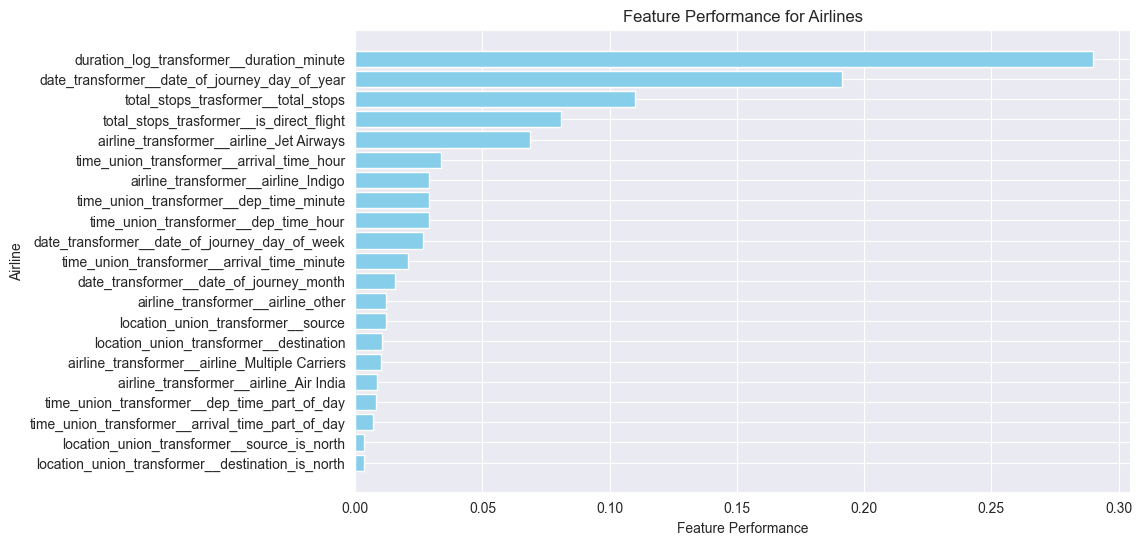

In [10]:
rf = RandomForestRegressor(max_depth=20, max_features=0.5, n_estimators=150)
rf.fit(X_train, y_train)

feature_imp_df = pd.DataFrame(
    {
        'feature_name' : rf.feature_names_in_,
        'importance': rf.feature_importances_
    }
).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_imp_df.feature_name, feature_imp_df.importance, color='skyblue')
plt.xlabel('Feature Performance')
plt.ylabel('Airline')
plt.title('Feature Performance for Airlines')
plt.gca().invert_yaxis()
plt.show()

## FINAL

In [11]:
airline_transformer = Pipeline(steps=[
    ('grouper', RareLabelEncoder(tol=0.1, replace_with='other', n_categories=2)),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

date_tranformer = Pipeline(steps=[
    ('date_to_features', DatetimeFeatures(features_to_extract=['month', 'day_of_week', 'day_of_year'], yearfirst=True, format='mixed')),
    ('min_max_scaler', MinMaxScaler())
])

location_transformer = Pipeline(steps=[
    ('grouper', RareLabelEncoder(tol=0.1, replace_with='other', n_categories=2)),
    ('mean_encoder', MeanEncoder()),
    ('power_transformer', PowerTransformer())
])

def is_north(X):
	columns = X.columns.to_list()
	north_cities = {"Delhi", "Kolkata", "Mumbai", "New Delhi"}
	return (
		X
		.assign(**{
			f"{col}_is_north": X.loc[:, col].isin(north_cities).astype(int)
			for col in columns
		})
		.drop(columns=columns)
	)

location_union_transformer = FeatureUnion(transformer_list=[
	("location_transformer", location_transformer),
	("is_north_transformer", FunctionTransformer(func=is_north))
])

time_transformer = Pipeline(
    steps = [
        ('dt', DatetimeFeatures(features_to_extract=['hour', 'minute'],  yearfirst=True, format='mixed')),
        ('scaler', MinMaxScaler())
    ]
)

def part_of_day(X, start=0 , mid=8, end=16):
    columns = X.columns.to_list()
    X_temp = X.assign(
        **{
            col: pd.to_datetime(X.loc[:, col]).dt.hour
            for col in columns
        }
    )
    return (
        X_temp
        .assign(
            **{
                f'{col}_part_of_day': np.select(
                    [
                        X_temp.loc[:, col].between(start, mid, inclusive='left'),
                        X_temp.loc[:, col].between(mid, end, inclusive='left')
                    ], choicelist = ['start', 'mid'] ,default = 'end'
                )
                for col in columns
            }
        ).drop(columns=columns)
    )

part_of_day_transformer = Pipeline(
    steps = [
        ('part_of_day_func', FunctionTransformer(func=part_of_day)),
        ('count_fre_encoder', CountFrequencyEncoder()),
        ('min_max_scaler', MinMaxScaler())
    ]
)

time_union_transformer = FeatureUnion(
    transformer_list=[
        ('time_transformer', time_transformer),
        ('part_of_day_transformer', part_of_day_transformer)
    ]
)

duration_log_transformer = FunctionTransformer(func=np.log)

def is_direct_flight(X):
    return X.assign(
        is_direct_flight = X.total_stops.eq(0).astype(int)
    )

total_stops_transformer = FunctionTransformer(func=is_direct_flight)

column_transformer = ColumnTransformer(transformers=[
    ('airline_transformer', airline_transformer, ['airline']),
    ('date_transformer', date_tranformer, ['date_of_journey']),
    ('location_union_transformer', location_union_transformer, ['source', 'destination']),
    ('time_union_transformer', time_union_transformer, ['dep_time', 'arrival_time']),
    ('duration_log_transformer', duration_log_transformer, ['duration_minute']),
    ('total_stops_trasformer', total_stops_transformer, ['total_stops'])
])

In [12]:
pipeline = Pipeline(steps=[
    ('preprocessor', column_transformer),  # ColumnTransformer
    ('random_forest_regressor', RandomForestRegressor(max_depth=20, max_features=0.5, n_estimators=150))  # RandomForestRegressor
])

In [13]:
X_train, y_train = get_dataset('train').drop(columns=['price','additional_info']), get_dataset('train').price.copy()
X_val, y_val = get_dataset('validation').drop(columns=['price','additional_info']), get_dataset('validation').price.copy()
X_test, y_test = get_dataset('test').drop(columns=['price','additional_info']), get_dataset('test').price.copy()

In [14]:
pipeline.fit(X_train, y_train)

print()
print('==========VALIDATION DATASET==========')
get_metrics(pipeline, X_val, y_val)

print()
print('==========TEST DATASET==========')
get_metrics(pipeline, X_test, y_test)


==========VALIDATION DATASET==========
R^2: 0.8116
Adjusted R^2: 0.8107
RMSE: 2021.6038

==========TEST DATASET==========
R^2: 0.8064
Adjusted R^2: 0.8056
RMSE: 1996.7124


In [15]:
X_train.head(1)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration_minute,total_stops
0,Multiple Carriers,2019-05-21,Delhi,Cochin,02:15:00,11:50:00,575,1


In [16]:
y_train.head(1).iloc[0]

14067

In [17]:
query = pd.DataFrame(
    {
            'airline': ['Multiple Carriers'],
            'date_of_journey': ['2019-05-21'],
            'source': ['Delhi'],
            'destination': ['Cochin'],
            'dep_time': ['02:15:00'],
            'arrival_time': ['11:50:00'],
            'duration_minute': [575],
            'total_stops': [1]
    }
)

print('===== OUTPUT =====>>>>', pipeline.predict(query)[0])

===== OUTPUT =====>>>> 13364.933333333332


In [18]:
# # Get input values
# airline = input("Enter airline: ")
# date_of_journey = input("Enter date of journey: ")
# source = input("Enter source: ")
# destination = input("Enter destination: ")
# dep_time = input("Enter departure time: ")
# arrival_time = input("Enter arrival time: ")
# duration_minute = int(input("Enter duration in minutes: "))
# total_stops = int(input("Enter total stops: "))

# # Create a dictionary with column names and input values
# data = {
#     'airline': [airline],
#     'date_of_journey': [date_of_journey],
#     'source': [source],
#     'destination': [destination],
#     'dep_time': [dep_time],
#     'arrival_time': [arrival_time],
#     'duration_minute': [duration_minute],
#     'total_stops': [total_stops]
# }

# query = pd.DataFrame(data)

# print()
# print('===== OUTPUT =====>>>>', pipeline.predict(query)[0])

In [19]:
with open('trained_model.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

In [20]:
with open('trained_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [21]:
query = pd.DataFrame(
    {
            'airline': ['Multiple Carriers'],
            'date_of_journey': ['2019-05-21'],
            'source': ['Delhi'],
            'destination': ['Cochin'],
            'dep_time': ['02:15:00'],
            'arrival_time': ['11:50:00'],
            'duration_minute': [575],
            'total_stops': [1]
    }
)

print('===== OUTPUT =====>>>>', loaded_model.predict(query)[0])

===== OUTPUT =====>>>> 13364.933333333332


In [22]:
# Ensure the 'model' directory exists, create it if it doesn't
os.makedirs('../model', exist_ok=True)

# Save the model to the 'model' directory
model_path = '../model/trained_model.pkl'
with open(model_path, 'wb') as file:
    pickle.dump(pipeline, file)